## Import Packages

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import geopandas as gpd
from scipy.stats import chi2_contingency, norm
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

C:\Users\rorya\anaconda3\envs\geo_env\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Read In File and Convert To Geopandas Dataframe

In [2]:
geocode_output = pd.read_excel('data/combined_files_output.xlsx', index_col=0) #First have to read in as a pandas 

CRS = "EPSG:4326"

#Create a geodataframe from the output using the points_from_xy command

gdf = gpd.GeoDataFrame(geocode_output, geometry=gpd.points_from_xy(geocode_output.Longitude, geocode_output.Latitude))

gdf.head()

,Status,Number_of_Properties,Consent,Minor Variance,Official Plan Rezoning,Site Plan Application,Latitude,Longitude,geometry,Council,Neighbourhood,Population_Density,Households_In_Core_Housing_Need,Average_Income,Secondary_Plan,Business_Improvement_Area,Site_and_Area_Specific_Policy,Zoning_Category
0,Approved,1,0,0,1,0,43.626854,-79.499656,POINT (-79.49966 43.62685),Etobicoke York Community Council,Stonegate-Queensway,3199,1715,64140,0,1,0,Commercial Residential
1,Approved,1,0,0,0,1,43.674647,-79.400973,POINT (-79.40097 43.67465),Toronto and East York Community Council,Annex,10863,2420,112766,0,0,0,Commercial Residential
2,Approved,1,1,0,0,0,43.652096,-79.547083,POINT (-79.54708 43.65210),Etobicoke York Community Council,Islington-City Centre West,2712,3470,52787,0,0,0,Residential
3,Approved,1,0,1,0,0,43.753666,-79.338064,POINT (-79.33806 43.75367),North York Community Council,Parkwoods-Donalda,4691,3255,42516,0,0,0,Residential
4,Approved,1,0,0,0,1,43.735174,-79.342838,POINT (-79.34284 43.73517),North York Community Council,Banbury-Don Mills,2775,2115,67757,1,0,0,Residential


In [3]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1522 entries, 0 to 1540
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Status                           1522 non-null   object  
 1   Number_of_Properties             1522 non-null   int64   
 2   Consent                          1522 non-null   int64   
 3   Minor Variance                   1522 non-null   int64   
 4   Official Plan Rezoning           1522 non-null   int64   
 5   Site Plan Application            1522 non-null   int64   
 6   Latitude                         1522 non-null   float64 
 7   Longitude                        1522 non-null   float64 
 8   geometry                         1522 non-null   geometry
 9   Council                          1522 non-null   object  
 10  Neighbourhood                    1522 non-null   object  
 11  Population_Density               1522 non-null   int64   
 12

## 1. Visualizing The Various Features

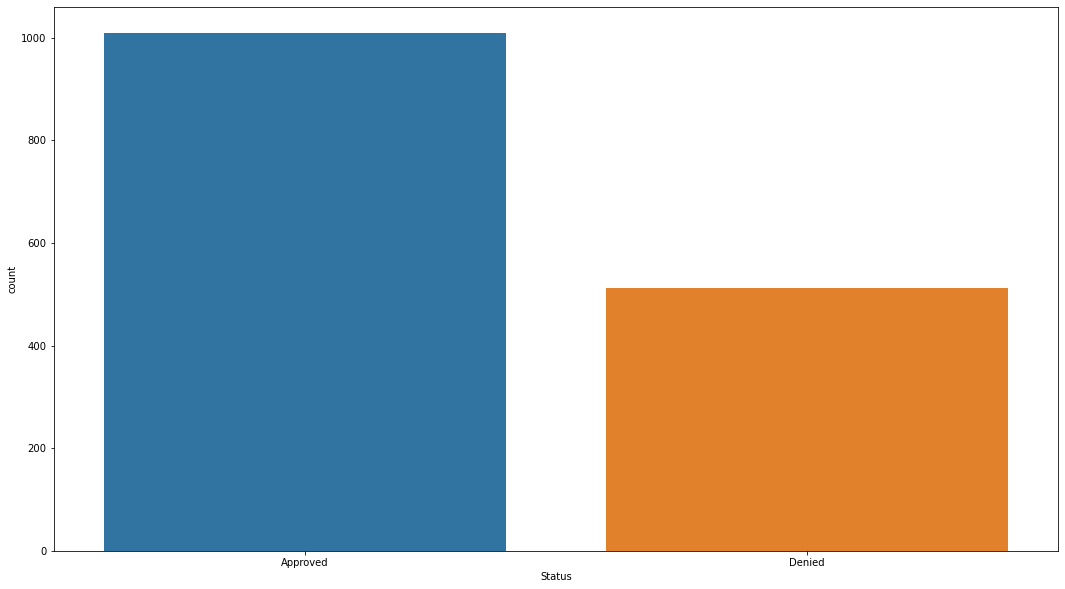

In [4]:
#Distribution of dependant feature

fig, ax = plt.subplots(figsize=[18,10])
sns.countplot(x = 'Status', data = gdf);

<AxesSubplot:xlabel='Number_of_Properties', ylabel='Density'>

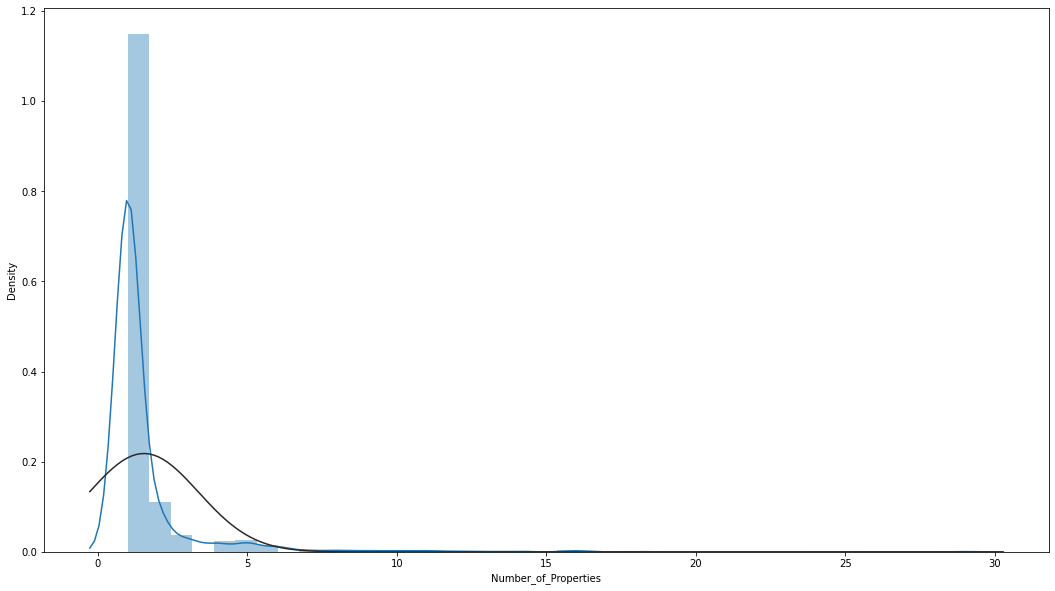

In [5]:
#Check distribution of number of properties

fig = plt.subplots(figsize=[18,10])
sns.distplot(gdf['Number_of_Properties'], fit=norm)

Because an overwhelming majority of applications having only one property, I will bin this feature and convert it into a categorical. For simplicity, I will have this new feature be a binary feature where an application has either one property or greater than one property.

In [6]:
#Bin number of properties into either one property or more than one property

gdf['Number_of_Properties'] = gdf['Number_of_Properties'].apply(lambda x: 'One Property' if x == 1 else 'More Than One Property')

In [7]:
gdf['Number_of_Properties'].value_counts()

One Property              1255
More Than One Property     267
Name: Number_of_Properties, dtype: int64

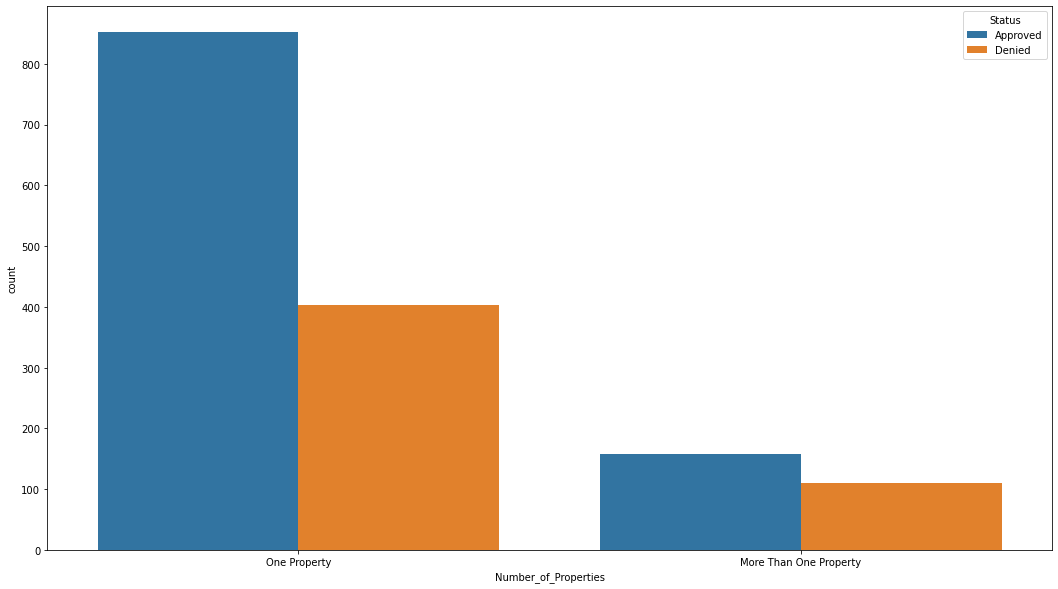

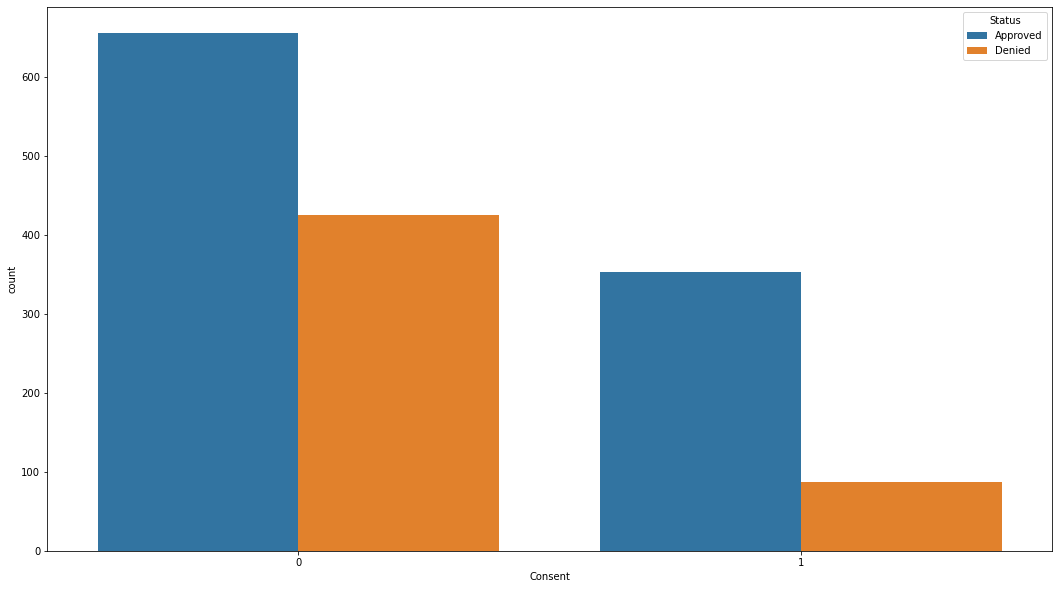

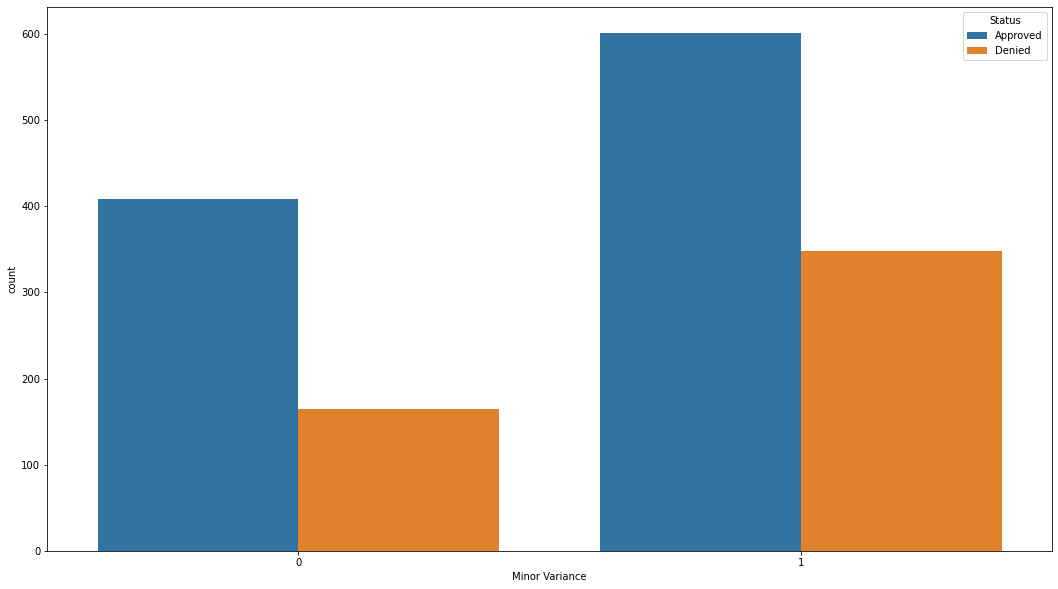

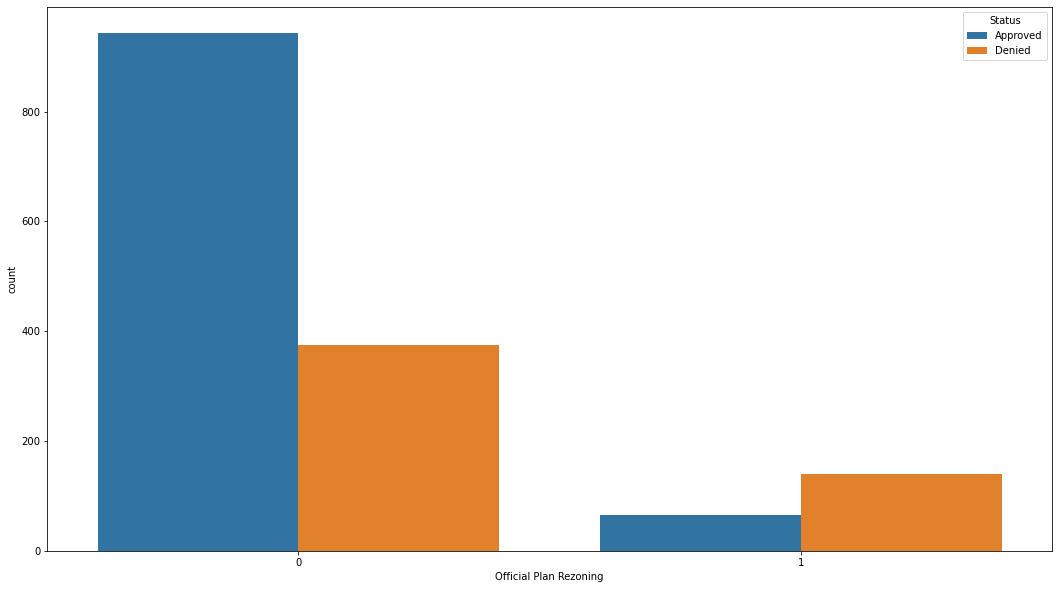

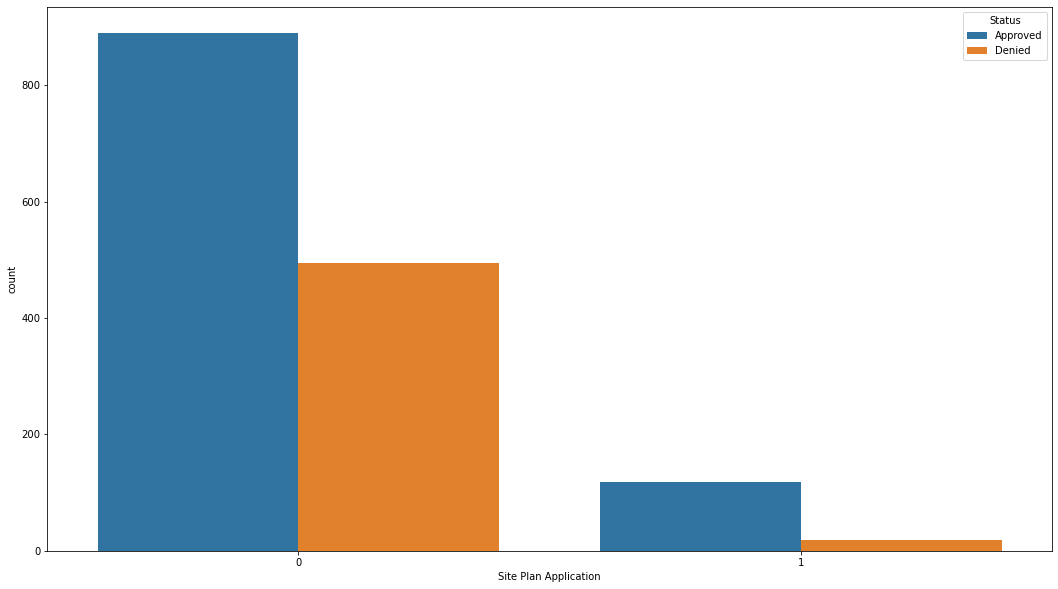

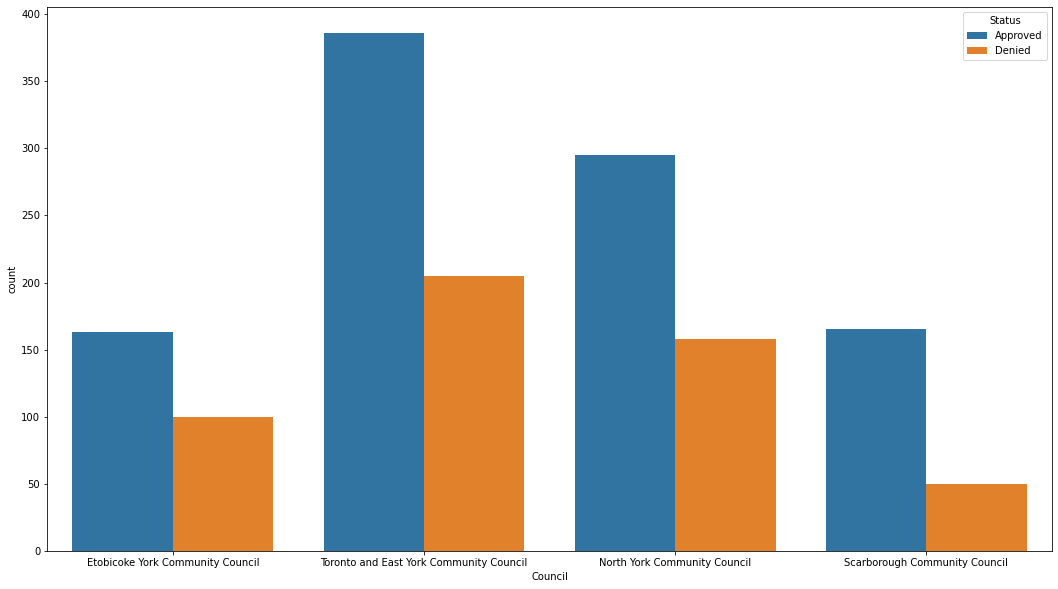

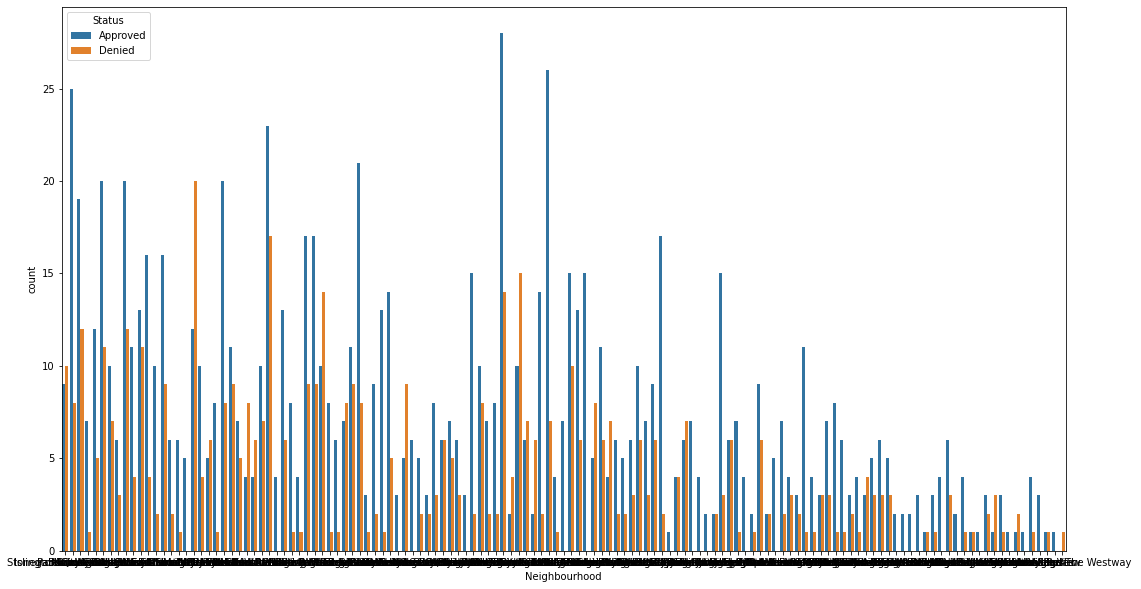

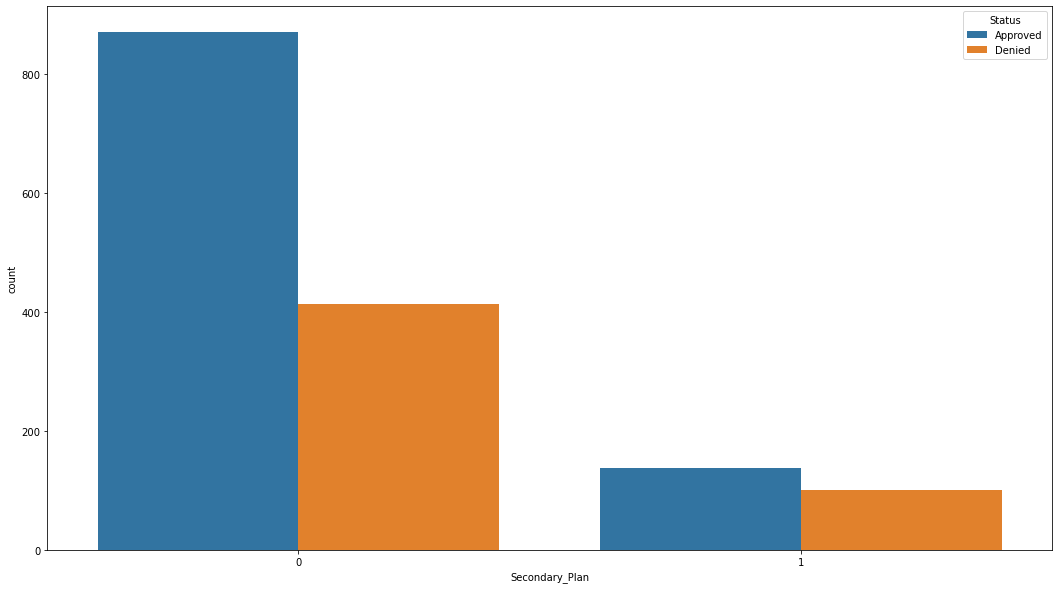

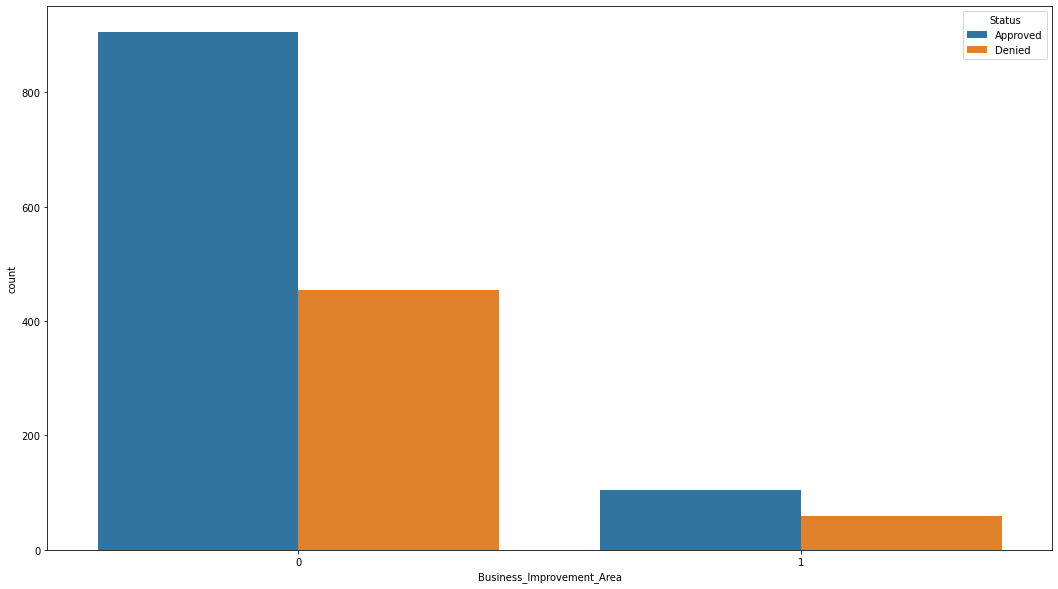

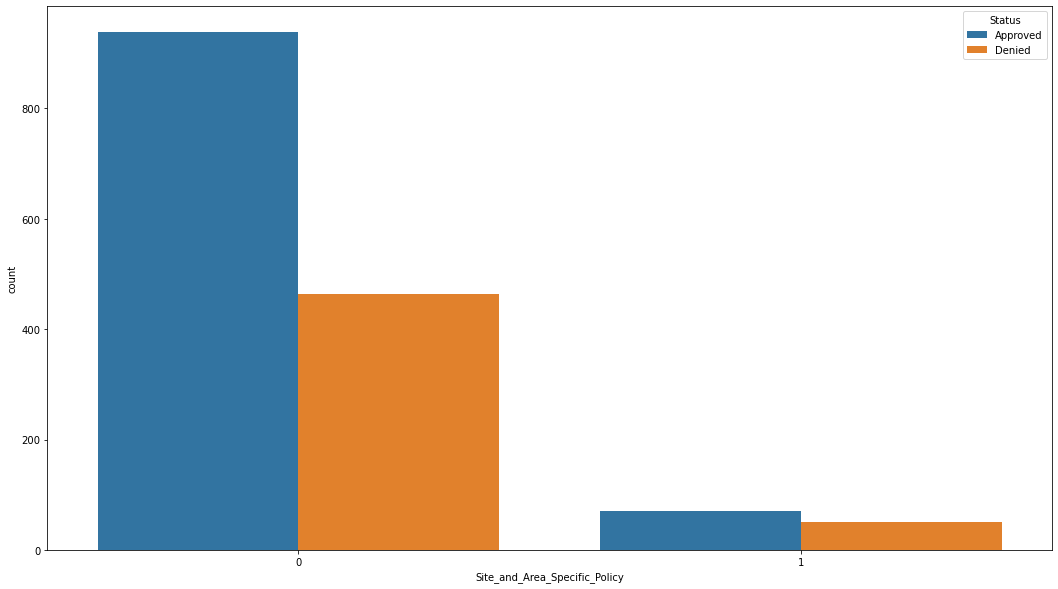

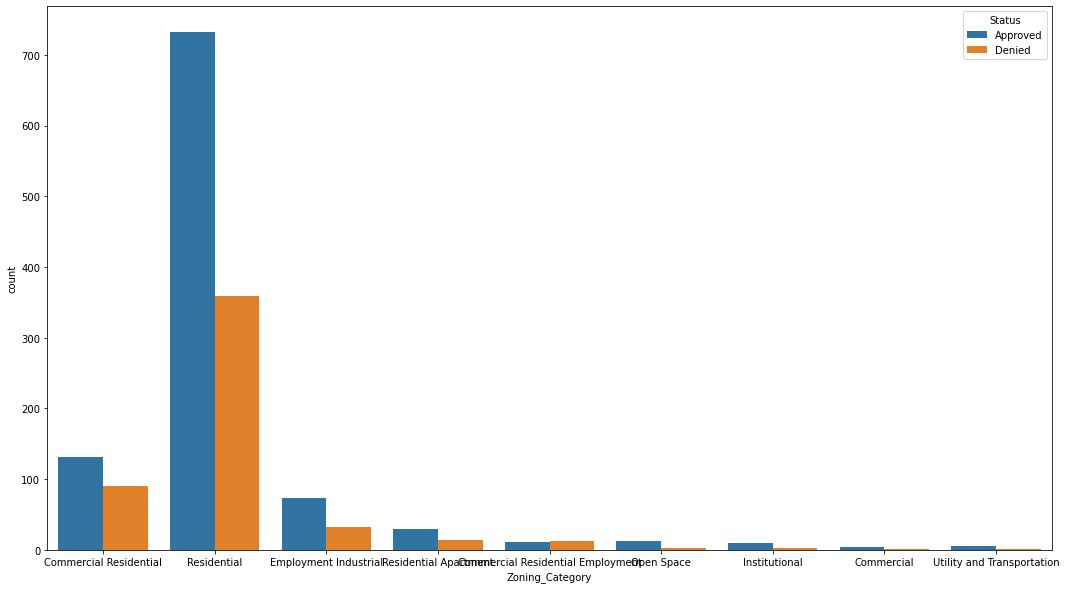

In [8]:
#Loop through all of the categorical features

categorical_cols = ['Number_of_Properties','Consent', 'Minor Variance', 'Official Plan Rezoning', 'Site Plan Application',
'Council','Neighbourhood','Secondary_Plan','Business_Improvement_Area','Site_and_Area_Specific_Policy', 'Zoning_Category']

for col in categorical_cols:
    fig, ax = plt.subplots(figsize=[18,10])
    sns.countplot(x = col, hue = 'Status' , data = gdf);

In [9]:
#Check number of neighbourhoods

gdf.Neighbourhood.nunique()

133

Takeaways:

- There is an imbalance in the number of approved and denied applications. This will need to be accounted for in the model training.
  
- When looking at the proportion of applications based on the number of properties, it appears that a larger proportion of applications with more than one property are denied compared to the applications with only one property.
  
- The majority of the applications are minor variance, of which almost half have been denied.
  
- While there are not as many official plan applications, the majority of them have been denied.
  
- Very few site plan applications have been denied.
  
- Not surprisingly Toronto and North York community councils have the largest volume of applications. These councils seem to fit the overall structure of the data, with nearly half of their applications being denied. It appears that Etobicoke has a larger proportion of denied applications, while Scarborough has a lower.

- I don't think it makes sense to include neighbourhood as a feature in the prediction model. There are 133 distinct neighbourhoods, which would greatly increase the dimensionality of the model. For simplicity, I will just include the council as multiple neighbourhoods can be consolidated down to a single council.
  
- There are very few applications that fall within either a secondary plan, business improvement, or site specific policy area. The proportions appears rather equal too, suggesting that these might not make for good features in predicting the outcome of an application.
  
- Not surprisingly the zoning category plot shows the majority of zoning types are residential. Most of the zoning categories have very few observations, and do not have a good balance between approved and denied. This shows that the zoning category is imbalanced and likely will not make for a good feature in predicting the outcome.

## 2. Statistical Tests

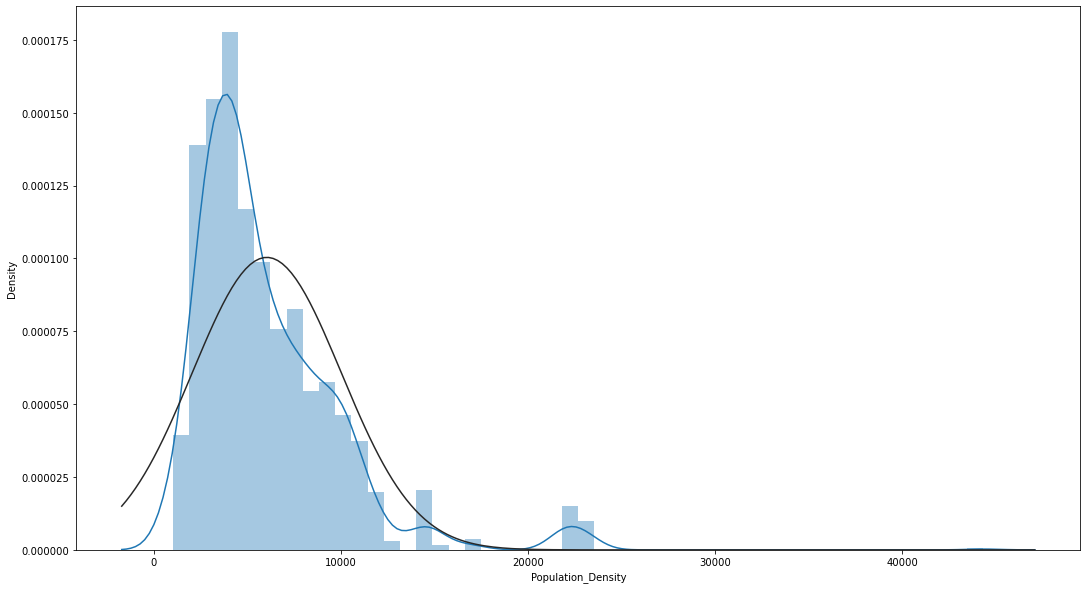

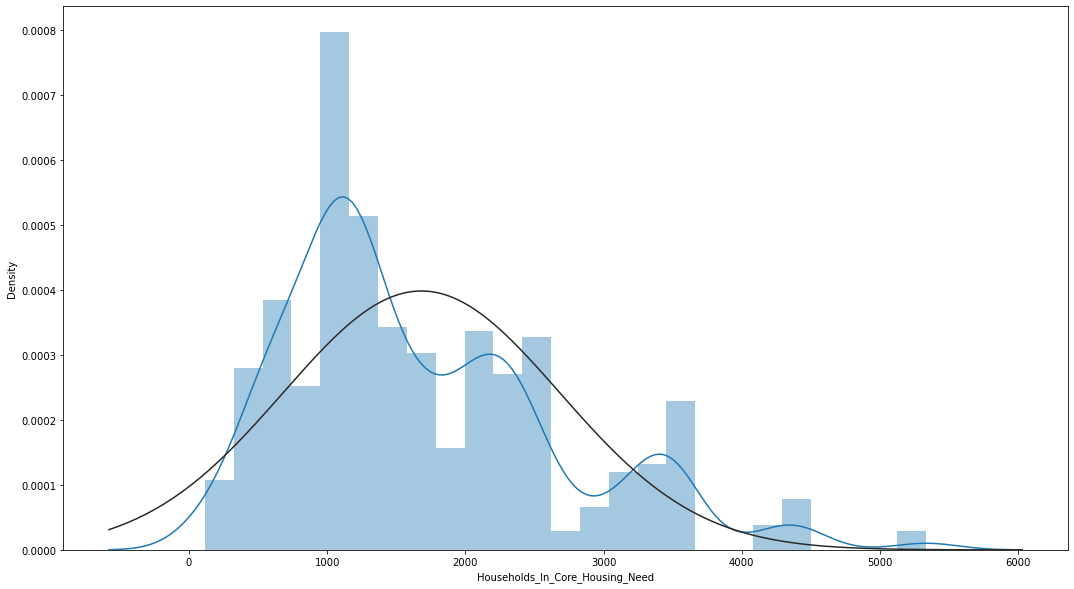

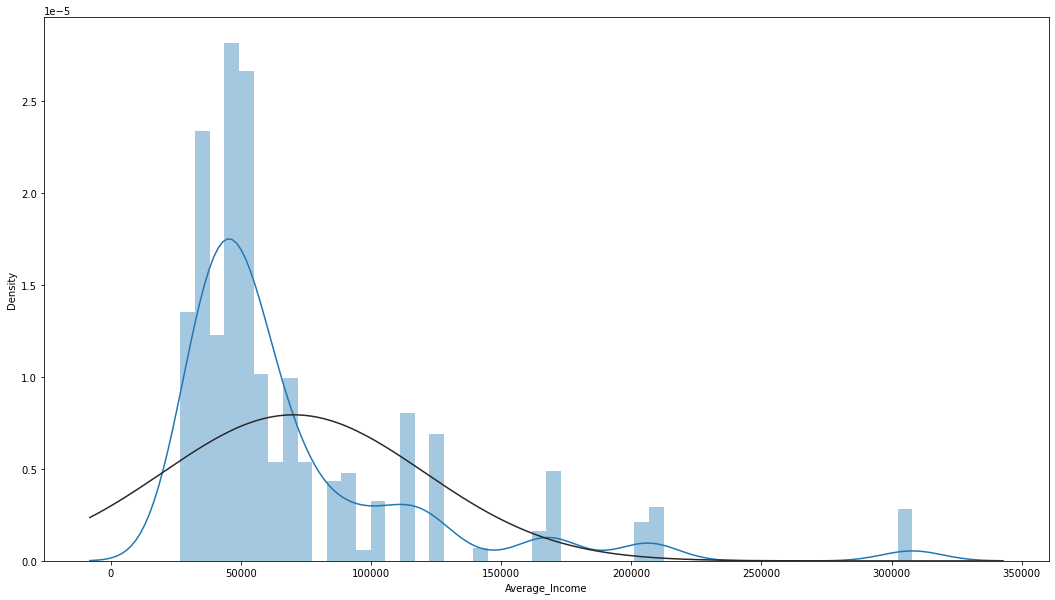

In [10]:
#Check distributions of numerical features

num_features = ['Population_Density', 'Households_In_Core_Housing_Need', 'Average_Income']

for i in num_features:
    fig, ax = plt.subplots(figsize=[18,10])
    sns.distplot(gdf[i], fit=norm)

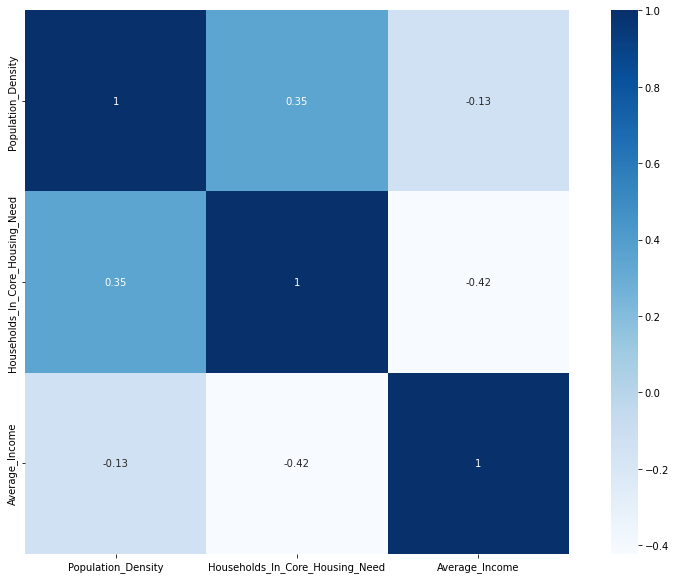

In [11]:
#Correlation heatmap

corrmat = gdf[num_features].corr()
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrmat, square=True, cmap = 'Blues', annot = True);

In [12]:
#Logistic regression test to see whether the numerical features would make for good features in predicting application status

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Xtrain = gdf[['Population_Density', 'Households_In_Core_Housing_Need', 'Average_Income']]
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtrain_final = pd.DataFrame(Xtrain_scaled, columns = Xtrain.columns) #Stores the values in a new dataframe to keep the column names

Ytrain = gdf['Status'].copy()
Ytrain.replace({'Approved': 1, 'Denied': 0}, inplace=True) #Convert status to binary outcomes
Ytrain = Ytrain.values.reshape(-1,1) #Reshape to fix endog and exog

log_reg = sm.Logit(Ytrain, Xtrain_final).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.688502
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1522
Model:                          Logit   Df Residuals:                     1519
Method:                           MLE   Df Model:                            2
Date:                Tue, 22 Feb 2022   Pseudo R-squ.:                -0.07736
Time:                        19:16:50   Log-Likelihood:                -1047.9
converged:                       True   LL-Null:                       -972.66
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Population_Density                 -0.0619      0.055     -1.128  

In [13]:
#Function to perform a chi-squared test of independence

def chi2_test_of_independence(dataframe,col1,col2):
    
    contingency= pd.crosstab(dataframe[col1], dataframe[col2]) #Converts columns to contingency table
    
    c, p, dof, expected = chi2_contingency(contingency) # Chi-square test of independence.
    
    print()
    
    if p <= 0.05:
        print(f"The chi-squared test resulted in a critical value of {c} with a p value of {p}.")
        print(f"It is likely that {col1} and {col2} are associated, and should be included in the prediction model (reject H0)")
    
    else:
        print(f"The chi-squared test resulted in a critical value of {c} with a p value of {p}.")
        print(f"It is likely that {col1} and {col2} are independent, and should be removed from the prediction model (fail to reject H0)")

In [14]:
# Chi-square test of association between categorical variables and application status

for col in categorical_cols:
    print(f"{col}")
    print(' — — — — — — — — ')
    chi2_test_of_independence(gdf,col,'Status')
    print()

Number_of_Properties
 — — — — — — — — 

The chi-squared test resulted in a critical value of 7.734157583610088 with a p value of 0.0054185837541374645.
It is likely that Number_of_Properties and Status are associated, and should be included in the prediction model (reject H0)

Consent
 — — — — — — — — 

The chi-squared test resulted in a critical value of 52.89712925286993 with a p value of 3.5148289126138107e-13.
It is likely that Consent and Status are associated, and should be included in the prediction model (reject H0)

Minor Variance
 — — — — — — — — 

The chi-squared test resulted in a critical value of 9.564945945445926 with a p value of 0.001983280393825326.
It is likely that Minor Variance and Status are associated, and should be included in the prediction model (reject H0)

Official Plan Rezoning
 — — — — — — — — 

The chi-squared test resulted in a critical value of 121.52272244717315 with a p value of 2.9361913278845813e-28.
It is likely that Official Plan Rezoning and Sta

## 4. Create The Final Dataframe For Modeling and Explore Page

In [15]:
gdf.head()

,Status,Number_of_Properties,Consent,Minor Variance,Official Plan Rezoning,Site Plan Application,Latitude,Longitude,geometry,Council,Neighbourhood,Population_Density,Households_In_Core_Housing_Need,Average_Income,Secondary_Plan,Business_Improvement_Area,Site_and_Area_Specific_Policy,Zoning_Category
0,Approved,One Property,0,0,1,0,43.626854,-79.499656,POINT (-79.49966 43.62685),Etobicoke York Community Council,Stonegate-Queensway,3199,1715,64140,0,1,0,Commercial Residential
1,Approved,One Property,0,0,0,1,43.674647,-79.400973,POINT (-79.40097 43.67465),Toronto and East York Community Council,Annex,10863,2420,112766,0,0,0,Commercial Residential
2,Approved,One Property,1,0,0,0,43.652096,-79.547083,POINT (-79.54708 43.65210),Etobicoke York Community Council,Islington-City Centre West,2712,3470,52787,0,0,0,Residential
3,Approved,One Property,0,1,0,0,43.753666,-79.338064,POINT (-79.33806 43.75367),North York Community Council,Parkwoods-Donalda,4691,3255,42516,0,0,0,Residential
4,Approved,One Property,0,0,0,1,43.735174,-79.342838,POINT (-79.34284 43.73517),North York Community Council,Banbury-Don Mills,2775,2115,67757,1,0,0,Residential


In [16]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1522 entries, 0 to 1540
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Status                           1522 non-null   object  
 1   Number_of_Properties             1522 non-null   object  
 2   Consent                          1522 non-null   int64   
 3   Minor Variance                   1522 non-null   int64   
 4   Official Plan Rezoning           1522 non-null   int64   
 5   Site Plan Application            1522 non-null   int64   
 6   Latitude                         1522 non-null   float64 
 7   Longitude                        1522 non-null   float64 
 8   geometry                         1522 non-null   geometry
 9   Council                          1522 non-null   object  
 10  Neighbourhood                    1522 non-null   object  
 11  Population_Density               1522 non-null   int64   
 12

## Explore Page

In [17]:
#Final df for explore page

explore_page_df = gdf.copy()

cols_to_drop = ['geometry','Neighbourhood','Population_Density','Households_In_Core_Housing_Need']

explore_page_df = explore_page_df.drop(columns=cols_to_drop)

explore_page_df = explore_page_df.rename(columns={'Latitude':'lat','Longitude':'lon',
                                                  'Minor Variance': 'Minor_Variance',
                                                  'Official Plan Rezoning':'Official_Plan_Rezoning',
                                                  'Site Plan Application':'Site_Plan_Application'}) 

#explore_page_df.to_csv('explore_page_data.csv')

## Predict Page

In [18]:
#Final df for model building

model_building_df = gdf.copy()
model_building_df = model_building_df[['Status','Number_of_Properties','Consent','Minor Variance','Official Plan Rezoning','Site Plan Application','Council',
'Secondary_Plan','Average_Income']]

model_building_df['Status'].replace({'Approved': 1, 'Denied': 0}, inplace=True) #Label encode status
model_building_df['Number_of_Properties'].replace({'One Property': 0, 'More Than One Property': 1}, inplace=True) #Label encode number of properties
dummies = pd.get_dummies(model_building_df.Council) #One hot encode council
model_building_df = pd.concat([model_building_df, dummies], axis = 1)
model_building_df.drop(columns=['Council'], inplace = True)

In [19]:
model_building_df.head()

,Status,Number_of_Properties,Consent,Minor Variance,Official Plan Rezoning,Site Plan Application,Secondary_Plan,Average_Income,Etobicoke York Community Council,North York Community Council,Scarborough Community Council,Toronto and East York Community Council
0,1,0,0,0,1,0,0,64140,1,0,0,0
1,1,0,0,0,0,1,0,112766,0,0,0,1
2,1,0,1,0,0,0,0,52787,1,0,0,0
3,1,0,0,1,0,0,0,42516,0,1,0,0
4,1,0,0,0,0,1,1,67757,0,1,0,0


In [20]:
#model_building_df.to_csv('predict_page.csv')

## Test Model Building

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [22]:
model = pd.read_csv('predict_page.csv', index_col= [0])
model.head()

,Status,Number_of_Properties,Consent,Minor Variance,Official Plan Rezoning,Site Plan Application,Secondary_Plan,Average_Income,Etobicoke York Community Council,North York Community Council,Scarborough Community Council,Toronto and East York Community Council
0,1,0,0,0,1,0,0,64140,1,0,0,0
1,1,0,0,0,0,1,0,112766,0,0,0,1
2,1,0,1,0,0,0,0,52787,1,0,0,0
3,1,0,0,1,0,0,0,42516,0,1,0,0
4,1,0,0,0,0,1,1,67757,0,1,0,0


In [23]:
model.head()

,Status,Number_of_Properties,Consent,Minor Variance,Official Plan Rezoning,Site Plan Application,Secondary_Plan,Average_Income,Etobicoke York Community Council,North York Community Council,Scarborough Community Council,Toronto and East York Community Council
0,1,0,0,0,1,0,0,64140,1,0,0,0
1,1,0,0,0,0,1,0,112766,0,0,0,1
2,1,0,1,0,0,0,0,52787,1,0,0,0
3,1,0,0,1,0,0,0,42516,0,1,0,0
4,1,0,0,0,0,1,1,67757,0,1,0,0


In [24]:
#Set X and y

X = model.drop("Status", axis=1)
y = model["Status"]

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [26]:
#Scale average income

income_scaler = StandardScaler()
x_train['Average_Income'] = income_scaler.fit_transform(x_train['Average_Income'].values.reshape(-1,1))
x_test['Average_Income'] = income_scaler.transform(x_test['Average_Income'].values.reshape(-1,1))

In [27]:
pipelines = {
    'Logistic': make_pipeline(LogisticRegression(random_state=1)),
    'RandomForest': make_pipeline(RandomForestClassifier(random_state=1))
    }

In [28]:
hyperparameters = {
    
'Logistic' : { 
    'logisticregression__C': [0.01, 0.1, 1, 10], 
    'logisticregression__penalty' : ['none','l1', 'l2'],
    'logisticregression__class_weight' : [None, {0:1,1:2},{0:1,1:5} ]
    },

'RandomForest' : {
     'randomforestclassifier__n_estimators' : [50, 100, 150, 200],
     'randomforestclassifier__min_samples_leaf' : [3, 5, 10, 15],
     'randomforestclassifier__max_depth' : [3, 5, 10, 15],
     'randomforestclassifier__class_weight' : [None, {0:1,1:2},{0:1,1:5}]
    }
    
}

In [29]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [30]:
fitted_models = {} #Establishes a dictionary that will hold the model and its best performing hyperparameters

# Grid search each model and hyperparameter with 5 fold cross validation

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, 
                         hyperparameters[name], 
                         cv=cv,
                         scoring='roc_auc',
                         return_train_score = False)
    model.fit(x_train, y_train)
    fitted_models[name] = model

In [31]:
for name, model in fitted_models.items():
   pred = model.predict(x_test)
   print(name)
   print(' — — — — ')
   print('Accuracy:', accuracy_score(y_test, pred))
   print('Precision:', precision_score(y_test, pred))
   print('Recall:', recall_score(y_test, pred))
   print('ROC AUC:', roc_auc_score(y_test, pred))
   print() 
   print('This models best performing parameters are ' + str(model.best_params_))
   print()

Logistic
 — — — — 
Accuracy: 0.6918032786885245
Precision: 0.694980694980695
Recall: 0.9230769230769231
ROC AUC: 0.6024475524475525

This models best performing parameters are {'logisticregression__C': 1, 'logisticregression__class_weight': None, 'logisticregression__penalty': 'l2'}

RandomForest
 — — — — 
Accuracy: 0.7049180327868853
Precision: 0.6909090909090909
Recall: 0.9743589743589743
ROC AUC: 0.6008158508158508

This models best performing parameters are {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__n_estimators': 150}



In [32]:
model.best_params_

{'randomforestclassifier__class_weight': None,
 'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__min_samples_leaf': 3,
 'randomforestclassifier__n_estimators': 150}